In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from estuary.util import tif_to_rgb

In [176]:
labels_path = Path("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
df_labels = pd.read_csv(labels_path)

df_labels.head(5)

region                                         source_tif  \
0  pismo_creek_lagoon  /Users/kyledorman/data/estuary/dove/results/20...   
1  pismo_creek_lagoon  /Users/kyledorman/data/estuary/dove/results/20...   
2  pismo_creek_lagoon  /Users/kyledorman/data/estuary/dove/results/20...   
3  pismo_creek_lagoon  /Users/kyledorman/data/estuary/dove/results/20...   
4  pismo_creek_lagoon  /Users/kyledorman/data/estuary/dove/results/20...   

                                         source_jpeg   label  
0  /Users/kyledorman/data/estuary/label_studio/00...    open  
1  /Users/kyledorman/data/estuary/label_studio/00...  closed  
2  /Users/kyledorman/data/estuary/label_studio/00...    open  
3  /Users/kyledorman/data/estuary/label_studio/00...  closed  
4  /Users/kyledorman/data/estuary/label_studio/00...    open

In [177]:
df_labels.groupby("region").label.value_counts().unstack(fill_value=0)

label                   closed  open  unsure
region                                      
big_sur_river               24   170       6
carmel                     135    64       1
goleta                      44   155       1
little_sur                  48   149       3
los_penasquitos_lagoon      29   163       8
malibu_lagoon               81   115       4
navarro_river              111    87       2
pismo_creek_lagoon          66   127       7
russian_river               26   169       5
san_dieguito_lagoon          0   200       0
san_elijo_lagoon            15   184       1
san_mateo_lagoon           170    27       3
santa_margarita              8   190       2
topanga                    141    56       3
ventura                     29   166       5

In [4]:
def center_crop(img, size):
    img = img.resize((512, 512))
    if size == 512:
        return img
    start = (512 - size) // 2
    end = start + size
    return img.crop((start, start, end, end))

In [17]:
def cropsize(size, center=None):
    if center is None:
        center = (256, 256)
    start_w = center[1] - size // 2
    end_w = start_w + size
    start_h = center[0] - size // 2
    end_h = start_h + size
    return (start_w, start_h, end_w, end_h)

In [143]:
region_crops = {
    "big_sur_river": cropsize(128),
    "carmel": cropsize(192),
    "goleta": cropsize(256, (260, 320)),
    "little_sur": cropsize(256 + 64, (320, 256)),
    "los_penasquitos_lagoon": cropsize(128, (230, 220)),
    "malibu_lagoon": cropsize(256),
    "navarro_river": cropsize(256 + 64, (350, 160)),
    "pismo_creek_lagoon": cropsize(256, (220, 256)),
    "russian_river": cropsize(320, (256, 180)),
    "san_dieguito_lagoon": cropsize(256),
    "san_elijo_lagoon": cropsize(192, (190, 160)),
    "san_mateo_lagoon": cropsize(128),
    "santa_margarita": cropsize(384, (230, 256)),
    "topanga": cropsize(128),
    "ventura": cropsize(192, (340, 260)),
}

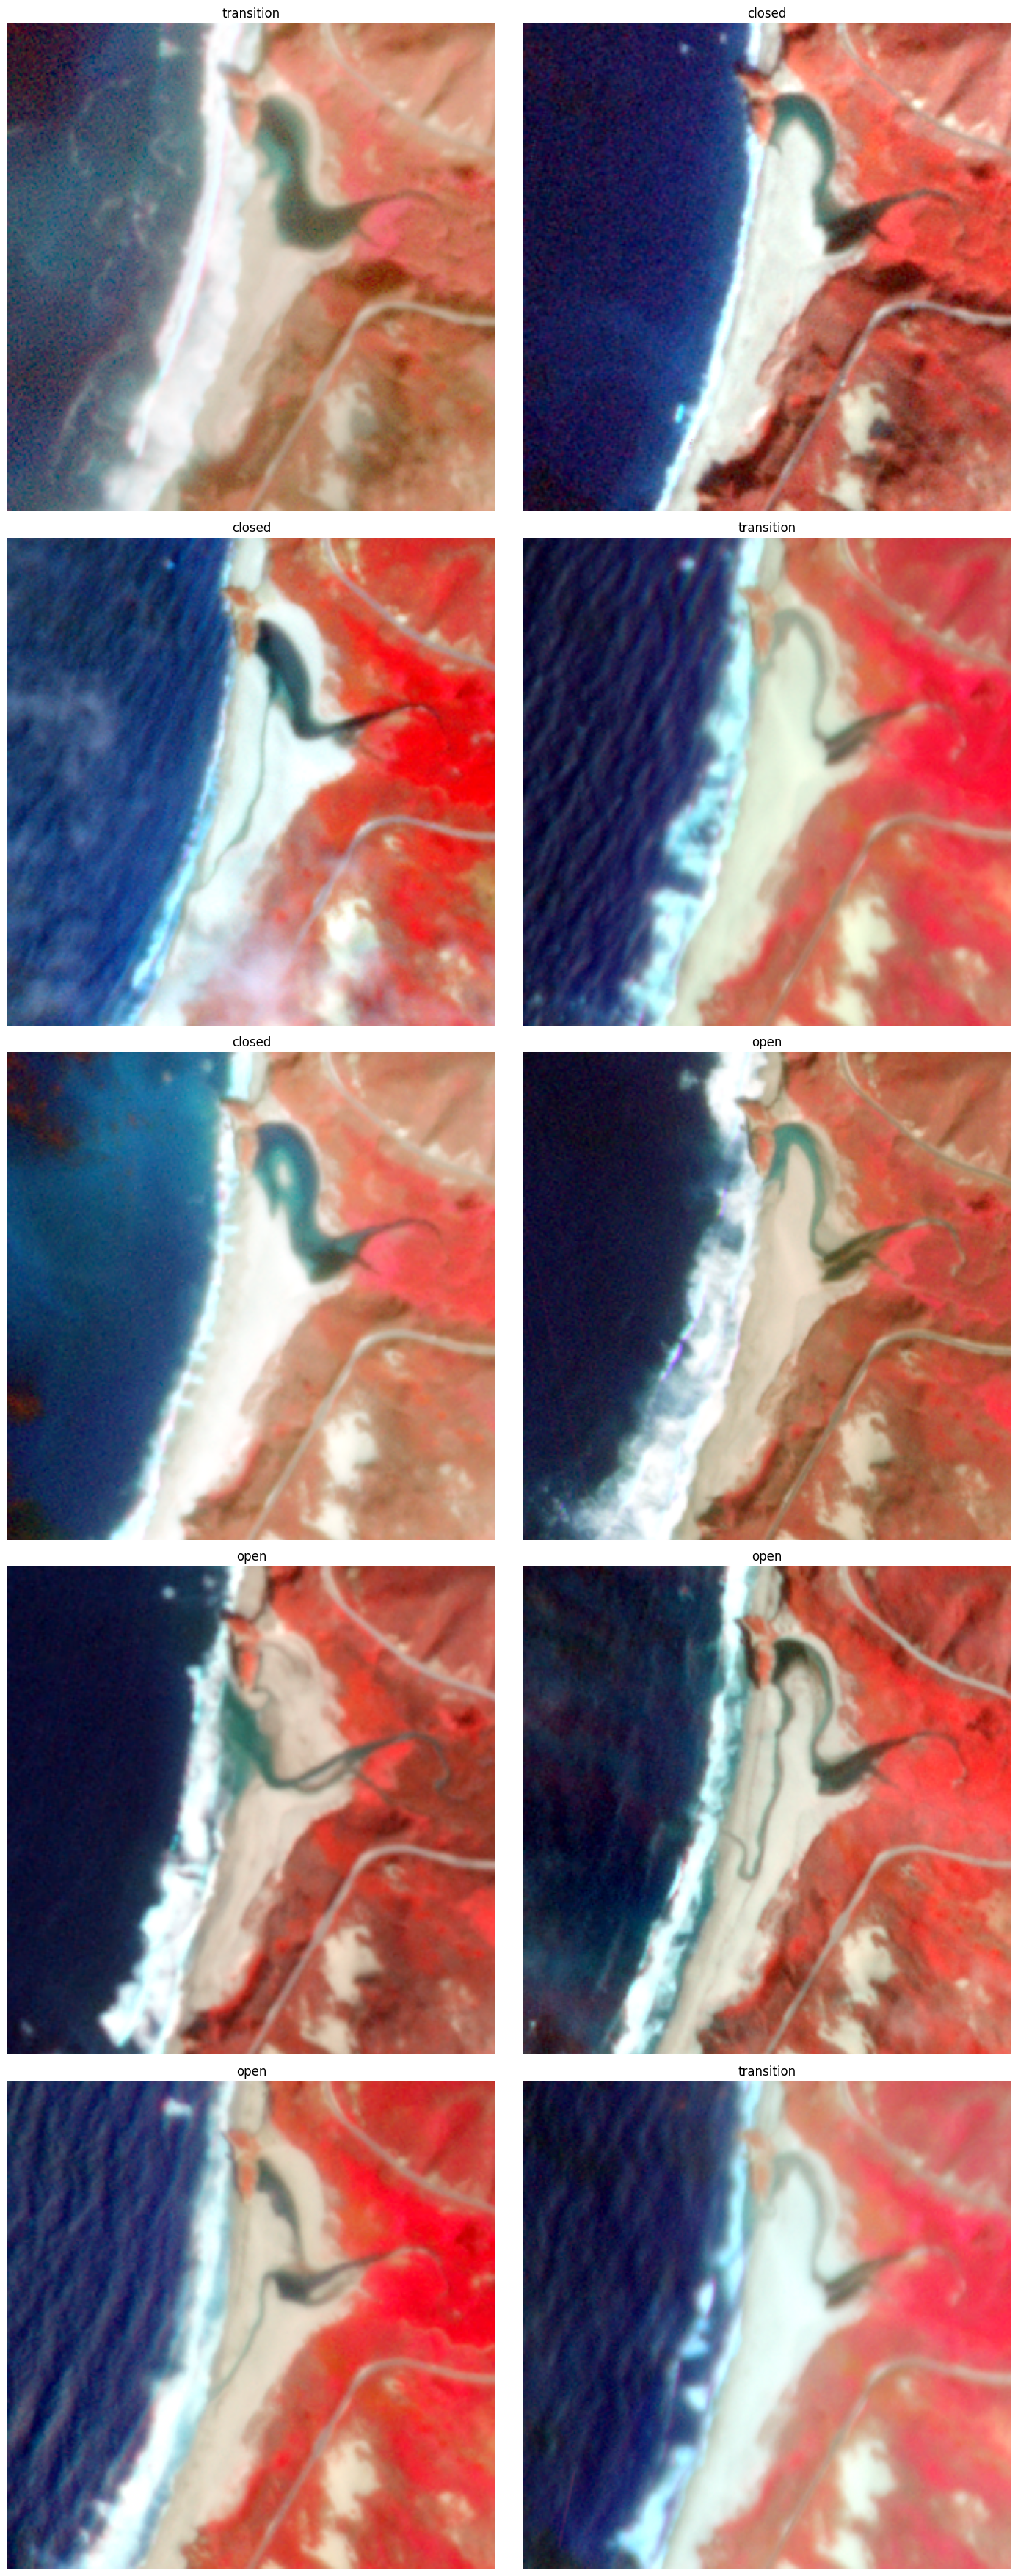

In [149]:
region = "little_sur"
start = 80
cols = 2
rows = 5
total = rows * cols
fig, axes = plt.subplots(
    nrows=rows, ncols=cols, figsize=(cols * 7, rows * 7), constrained_layout=True
)
rdf = df_labels[df_labels.region == region]
for r, (_, row) in enumerate(rdf.iloc[start : start + total].iterrows()):
    i = r // cols
    j = r % cols
    img_pth = Path(row.source_tif)
    img = tif_to_rgb(img_pth)
    img = Image.fromarray(img)
    if region in region_crops:
        img = img.crop(region_crops.get(region))  # .resize((512, 512), Image.BILINEAR)
    axes[i, j].axis("off")
    axes[i, j].imshow(img)
    axes[i, j].set_title(row.label)
plt.show()

In [ ]:
def df_iter_region_label(df):
    labels = ["closed", "open", "unsure"]
    for region, rdf in df.groupby("region"):
        for label in labels:
            yield region, label, rdf[rdf.label == label]

In [ ]:
# prompts = {}
label_iter = df_iter_region_label(df_labels)

In [ ]:
region, label, matches = next(label_iter)
while region == "big_sur_river":
    region, label, matches = next(label_iter)
if region not in prompts:
    prompts[region] = {}
if label not in prompts[region]:
    prompts[region][label] = []

print(region, label, len(matches.source_jpeg))
if len(matches):
    pths = matches.source_jpeg.sample(min(len(matches), 9))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), constrained_layout=True)

    for i, (ax, ip) in enumerate(zip(axes.flatten(), pths, strict=False)):
        # print(ip)
        img = cv2.imread(ip)[:, :, ::-1]
        ax.axis("off")
        ax.set_title(str(i))
        ax.imshow(img)
    plt.show()

In [ ]:
prompts[region][label].append(matches.source_jpeg.iloc[8])
# prompts[region][label].append(matches.source_jpeg.iloc[0])

In [ ]:
with open("/Users/kyledorman/data/estuary/label_studio/00023/prompt.json", "w") as f:
    json.dump(prompts, f)

In [182]:
predictions_path = Path("/Users/kyledorman/data/estuary/label_studio/00025/")

# --- Load data ---
df_preds = pd.read_csv(predictions_path)

# Count unsure vs unsure-extra **before** mapping
unsure_count = (df_preds["pred"] == "unsure").sum()

# Keep only valid ground-truth classes
valid_gt = {"open", "closed", "unsure"}
eval_df = df_preds[df_preds["label"].isin(valid_gt)].copy()
if eval_df.empty:
    raise ValueError("No valid ground-truth rows after filtering.")

# Overall accuracy
accuracy = (eval_df["label"] == eval_df["pred"]).mean()

# Per-class precision/recall
rows = []
for cls in sorted(valid_gt):
    tp = ((eval_df["label"] == cls) & (eval_df["pred"] == cls)).sum()
    fp = ((eval_df["label"] != cls) & (eval_df["pred"] == cls)).sum()
    fn = ((eval_df["label"] == cls) & (eval_df["pred"] != cls)).sum()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    rows.append(
        {
            "class": cls,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "precision": precision,
            "recall": recall,
        }
    )

per_class_df = pd.DataFrame(rows)
macro_precision = per_class_df["precision"].mean()
macro_recall = per_class_df["recall"].mean()

print("=== Summary Metrics ===")
print(f"Evaluated images: {len(eval_df)}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Predictions 'unsure': {unsure_count}")

print("\n=== Per-Class Metrics ===")
display(per_class_df)

print("\nSample evaluated rows:")
display(eval_df.head())

=== Summary Metrics ===
Evaluated images: 1292
Accuracy: 0.519
Macro Precision: 0.458
Macro Recall: 0.523
Predictions 'unsure': 76

=== Per-Class Metrics ===


class   tp   fp   fn  precision    recall
0  closed  111  177  404   0.385417  0.215534
1    open  527  401  199   0.567888  0.725895
2  unsure   32   44   19   0.421053  0.627451


Sample evaluated rows:


Unnamed: 0         region  \
0           0  big_sur_river   
1           1  big_sur_river   
2           2  big_sur_river   
3           3  big_sur_river   
4           4  big_sur_river   

                                         source_jpeg  \
0  /Users/kyledorman/data/estuary/label_studio/00...   
1  /Users/kyledorman/data/estuary/label_studio/00...   
2  /Users/kyledorman/data/estuary/label_studio/00...   
3  /Users/kyledorman/data/estuary/label_studio/00...   
4  /Users/kyledorman/data/estuary/label_studio/00...   

                                          source_tif    pred   label  
0  /Users/kyledorman/data/estuary/dove/results/20...    open  closed  
1  /Users/kyledorman/data/estuary/dove/results/20...    open  closed  
2  /Users/kyledorman/data/estuary/dove/results/20...  closed  closed  
3  /Users/kyledorman/data/estuary/dove/results/20...  closed  closed  
4  /Users/kyledorman/data/estuary/dove/results/20...  closed  closed